In [4]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

# Define the path to the dataset. You can change this to your local file path if needed.
path = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
#Read the ECG dataset into a Pandas DataFrame

data=pd.read_csv(path, header=None)

In [5]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4998 entries, 0 to 4997
Columns: 141 entries, 0 to 140
dtypes: float64(141)
memory usage: 5.4 MB


In [9]:
# Splitting the dataset into features and target
features = data.drop(140, axis=1) # Features are all columns except the last (column 140)
target = data[140] # Target is the last column (column 140)

#Split the data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2
)

#Get the indices of the training data points labeled as "1" (anomalies)
train_index = y_train[y_train == 1].index

# Select the training data points that are anomalies
train_data = x_train.loc[train_index]

In [11]:
# Initialize the Min-Max Scaler to scale the data between 0 and 1
min_max_scaler = MinMaxScaler (feature_range=(0, 1))

# Scale the training data
x_train_scaled = min_max_scaler.fit_transform(train_data.copy())

# Scale the testing data using the same scaler
x_test_scaled = min_max_scaler.transform(x_test.copy())

In [15]:
# Creating an Autoencoder model by extending the Model class from Keras
class AutoEncoder(Model):
    def __init__(self, output_units, ldim=8):
        super().__init__()

        # Define the encoder part of the Autoencoder
        self.encoder = Sequential([
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(ldim, activation='relu')
        ])

        # Define the decoder part of the Autoencoder
        self.decoder = Sequential([
            Dense(16, activation='relu'),
            Dropout(0.1),
            Dense(32, activation='relu'),
            Dropout(0.1),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(output_units, activation='sigmoid')
        ])

    def call(self, inputs):
        # Forward pass through the Autoencoder
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded


In [16]:
# Create an instance of the AutoEncoder model with the appropriate output units
model = AutoEncoder(output_units=x_train_scaled.shape[1])

# Compile the model with Mean Squared Logarithmic Error (MSLE) loss and Mean Squared Error (MSE) metric
model.compile(loss='msle', metrics=['mse'], optimizer='adam')

# Train the model using the scaled training data
history=model.fit(
x_train_scaled,

# Input data for training
x_train_scaled,

# Target data for training (autoencoder reconstructs the input)
epochs=20,

#Number of training epochs
batch_size=512,

# Batch size
validation_data=(x_test_scaled, x_test_scaled), # Validation data

shuffle=True

# Shuffle the data during training

)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0104 - mse: 0.0235 - val_loss: 0.0128 - val_mse: 0.0298
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0100 - mse: 0.0225 - val_loss: 0.0126 - val_mse: 0.0292
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0089 - mse: 0.0200 - val_loss: 0.0127 - val_mse: 0.0294
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0079 - mse: 0.0177 - val_loss: 0.0126 - val_mse: 0.0292
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0070 - mse: 0.0156 - val_loss: 0.0121 - val_mse: 0.0280
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0060 - mse: 0.0133 - val_loss: 0.0118 - val_mse: 0.0274
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0052 - mse: 0.0117 - val_loss: 0.0114 - val_mse: 0.0264
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0047 - mse: 0.0106 - val_loss: 0.0111 - val_mse: 0.0258
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0045 - mse: 0.0101 - 

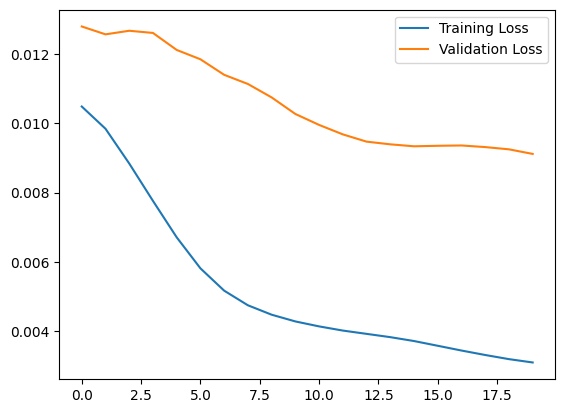

In [17]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()